# Point Manipulation

We use Lego as the example to show how to render the deformed scenes with point manipulation.

In addition to normal rendering part, we also use MeshLab & Open3D to select and deform points.


In [57]:
import os, sys
import open3d as o3d
import numpy as np

sys.path.append('../')
from pcd_editing import write_pth, get_pcd

## 1. Get Point Cloud from ckpt

In [60]:
save_dir = '../../checkpoints/nerfsynth_sdf/lego/'
pth_file = save_dir + '180000_net_ray_marching.pth'
get_pcd(pth_file, save_dir + '180000_pcd.ply')

Note that we use point attribute `quality` to store the index of the points.
Since MeshLab export point cloud will reorder the points, we need to store the index to recover the order.
MeshLab only read limited attribute fields of ply file, as the compromise, we use `quality` to store the index.

## 2. Select Points you want to deform

Use MeshLab to open the exported point cloud, and select the points you want to deform.

For example

![](figs/sel_point_meshlab.png)

After selection, you can export the selected points to a new ply file. Remember the toggle the vertex `Flags` attribute.

![](figs/pcd_export_meshlab.png)

For example, we provide a selected point cloud `lego/180000_pcd_sel.ply` in the shared folder.

## 3. Deform the selected points

Use Open3D to open the selected point cloud, and deform the points.

You can also use MeshLab to deform the points, but it is hard to generate a sequence of deformations with MeshLab.

In [103]:
pcd = o3d.t.io.read_point_cloud('../../checkpoints/nerfsynth_sdf/lego/180000_pcd_sel.ply')
pcd_idx = pcd.point['quality'].numpy()[...,0].astype(np.int64)
pcd_sel_mask = pcd.point.flags.numpy()[...,0] > 0

In [104]:
pcd_rot = pcd.select_by_mask(pcd_sel_mask)
pcd_fix = pcd.select_by_mask(pcd_sel_mask, True)

Choose the rotation center, and rotate the points.

In [105]:
rot_center = np.array([0, -0.060369, 0.175077]) # center of rotation
rot_mat = o3d.geometry.get_rotation_matrix_from_xyz((30/180*np.pi, 0, 0))

pcd_rot.rotate(rot_mat, rot_center)


PointCloud on CPU:0 [110954 points (Float32)].
Attributes: normals (dtype = Float32, shape = {110954, 3}), alpha (dtype = UInt8, shape = {110954, 1}), flags (dtype = Int32, shape = {110954, 1}), colors (dtype = UInt8, shape = {110954, 3}), quality (dtype = Float32, shape = {110954, 1}).

In [106]:
pcd_merge = pcd_rot + pcd_fix
pcd_merge_order = pcd_merge.point.quality.numpy()[...,0].astype(np.int64)
pcd_merge_idx = np.argsort(pcd_merge_order)
pcd_merge_sort = pcd_merge.select_by_index(pcd_merge_idx)


In [107]:
pcd_sel_mask_ordered = pcd_merge_sort.point.flags.numpy()[...,0] > 0
(pcd_sel_mask_ordered == pcd_sel_mask).all()

True

In [108]:
pth_new_file = save_dir + '180010_net_ray_marching.pth'
write_pth(pth_file, pth_new_file, pcd_merge_sort, pcd_sel_mask, rot_mat)

## 4. Render the deformed scene

You can directly render the deformed scene without illumination updates:

In [97]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/lego.ini --run_mode=sdf --split=test --resume_iter 180010 --test_start_id 50 --test_end_id 55

The illumination updates require to re-bake the depth maps from the light sources (since the object geometry has changed):

In [110]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/lego.ini --run_mode=sdf --bake_light --down_sample=0.5 --resume_iter=180010 --SR=60

Then we can render the deformed scene with illumination updates:

In [111]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/lego.ini --run_mode=lighting --split=test --resume_iter 180010 --test_start_id 70 --test_end_id 75

Text(0.5, 1.0, 'PBR')

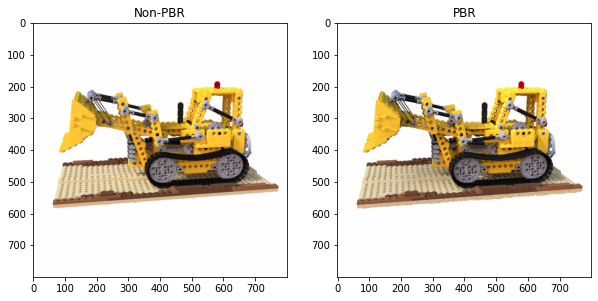

In [112]:
import matplotlib.pyplot as plt

non_pbr = '../../checkpoints/nerfsynth_sdf/lego/test_180010/images/step-0072-coarse_raycolor.png'
pbr = '../../checkpoints/nerfsynth_sdf/lego/test_180010/images/step-0072-brdf_combine_raycolor.png'

non_pbr = plt.imread(non_pbr)
pbr = plt.imread(pbr)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(non_pbr)
plt.title('Non-PBR')
plt.subplot(1,2,2)
plt.imshow(pbr)
plt.title('PBR')